Welcome to a brief walkthrough of audio data augmentation! This notebook leverages augmentation tools we've developed, which call libraries like `librosa` or `Pedalboard` under the hood. Read on to learn about a few methods for creating, customizing and evaluating audio augmentations.

# Initialization and setup

In [1]:
# Since we are not pip installing this package, we will need to manually specify the module path for packages import
# General note: local import paths may need to be updated, or place this notebook in model_dev dir
# and adjust augment_audio import to: import augment_audio

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# augmentation helper functions for this notebookimport augment_audio
from model_development import augment_audio

# Imports not dependent on local path structure
from IPython.display import Audio # listen to audio files from within Jupyter
from pedalboard import LowpassFilter, Pedalboard, Reverb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import librosa
import numpy as np
import pandas as pd

# notebook defaults and initializations
RANDOM_STATE = 42
SAMPLE_RATE = 44100 # to be passed to librosa and helper functions as needed
tqdm.pandas() # bring in progress_apply from tqdm for Pandas DataFrames

# helper function to avoid specifying sample rate for every audio evaluation
def audio_sr(signal, sample_rate=SAMPLE_RATE):
    return Audio(signal, rate=sample_rate)

# Data Preparation

## Use prepared audio clips as a basis for augmentation

In this notebook, we'll use a small subset of 100 processed data samples resulting from the `data_preparation.py` script. Note that although this script has integrated support for augmentation functions (via `.augment_audio`), this notebook serves as a hands-on demonstration for creating, tweaking, and visualizing augmentations in the waveform and Mel-spectrogram domains. The augmentation tools used here are contained within the `augment_audio.py` script.

In [2]:
# Import a sample subset of preprocessed audio (via data_preparation script)
audio_df = pd.read_pickle('sample_data/single_hit_samples.pkl') # update/replace filepath as needed

In [3]:
audio_df # .sample(5, random_state=RANDOM_STATE)

,label,audio_wav_resample,resample_sr
0,SD,"[0.0039152713, 0.006579694, 0.004075836, 0.006...",41160
1,HH_close,"[-0.009168873, -0.009878357, -0.009003086, -0....",44092
2,HH_open,"[-0.00015258789, -0.00018310547, -9.1552734e-0...",44100
3,HH_close,"[0.002319336, 0.00032043457, 0.00079345703, 0....",44100
4,FT,"[0.012298584, 0.010787964, 0.012191772, 0.0118...",44100
...,...,...,...
95,HH_close,"[-0.0045166016, 0.00090026855, 0.0061035156, -...",44100
96,HH_close,"[-0.008977206, -0.015808476, -0.012923383, -0....",41160
97,SD,"[0.00021782095, 0.00017324818, 9.722247e-05, 8...",47492
98,SD,"[0.00050354004, 0.00044250488, 0.00045776367, ...",44100


# Waveform augmentation

Next, let's create augmentations of the resampled audio waveforms in four ways: white noise, pitch, reverb, and via a lowpass filter. The `apply_augmentations` function in turn calls the four functions necessary to create these augmentations. Each has default parameters, although the dictionary below allows for easy customization. Check out the `augment_audio.py` script for additional documentation and usage examples.

In [4]:
# for reverb-only pedalboard (a Pedalboard object can easily include augmentation chains)
pb_reverb = Pedalboard([Reverb(room_size=0.6)])

waveform_aug_params = {
    'add_white_noise': {'snr':15, 'random_state': RANDOM_STATE}, # SNR: signal to noise ratio
    'augment_pitch': {'n_steps':3, 'step_var':range(-1, 2, 1)}, # step_var is the range of variation
    'add_pedalboard_effects': {'pb': pb_reverb},
    'add_lowpass_filter': {'cutoff_freq':500}
}

waveform_aug_colnames = ['white_noise_aug', 'pitch_aug', 'reverb_aug', 'lowpass_aug']

In [5]:
aug_audio_df = augment_audio.apply_augmentations(
    df=audio_df,
    audio_col='audio_wav_resample',
    aug_col_names=waveform_aug_colnames,
    **waveform_aug_params
)

Applying add_white_noise


  0%|          | 0/100 [00:00<?, ?it/s]

Applying augment_pitch


  0%|          | 0/100 [00:00<?, ?it/s]

Applying add_pedalboard_effects


  0%|          | 0/100 [00:00<?, ?it/s]

Applying add_lowpass_filter


  0%|          | 0/100 [00:00<?, ?it/s]

## Auditory evaluation

Before visualizing the augmented waveforms, it may help to first evaluate them by ear. It may even be a good idea to radically alter the parameters in the augmentations above and then listen again and examine how the sounds change. This helps develop one's intuition for parameter choices that are too minimal or extreme.

Clip instance 19 is a kick drum which will be used for the following comparisons.

In [6]:
i = 19

In [7]:
# Original
clip = aug_audio_df.loc[i, 'audio_wav_resample']
audio_sr(clip)

In [8]:
# White noise - if some static is not audible, consider lowering the SNR; increase if too much static
clip = aug_audio_df.loc[i, waveform_aug_colnames[0]]
audio_sr(clip)

In [9]:
# Pitch Shift: adding too many pitch shift steps results in a metallic distortion
# Tip: it may help to listen to the original again to notice the difference in pitch
clip = aug_audio_df.loc[i, waveform_aug_colnames[1]]
audio_sr(clip)

In [10]:
# Reverb
clip = aug_audio_df.loc[i, waveform_aug_colnames[2]]
audio_sr(clip)

In [11]:
# Lowpass filter
clip = aug_audio_df.loc[i, waveform_aug_colnames[3]]
audio_sr(clip)

## Visually compare waveforms

Next, let's compare each augmented waveform by overlaying it with the original kick drum clip.

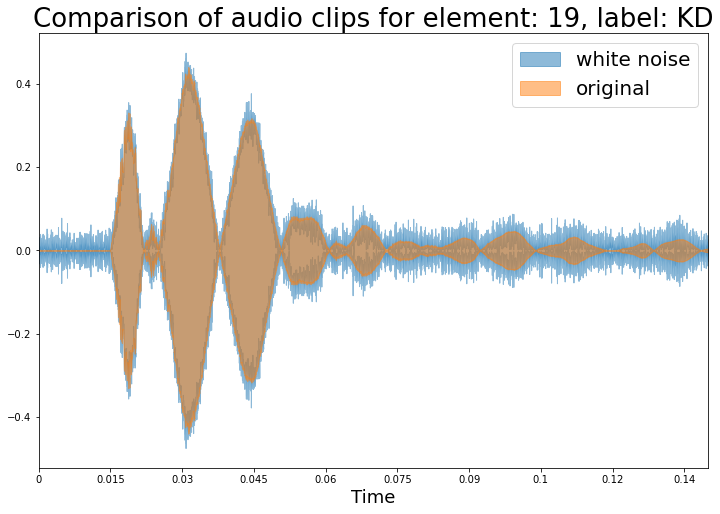

In [12]:
augment_audio.compare_waveforms(
    df=aug_audio_df,
    i=i,
    signal_cols=['white_noise_aug', 'audio_wav_resample'],
    signal_labs=['white noise', 'original'],
    alpha=0.5,
    fontsizes=[26, 18, 20],
    figsize=(12, 8)
)

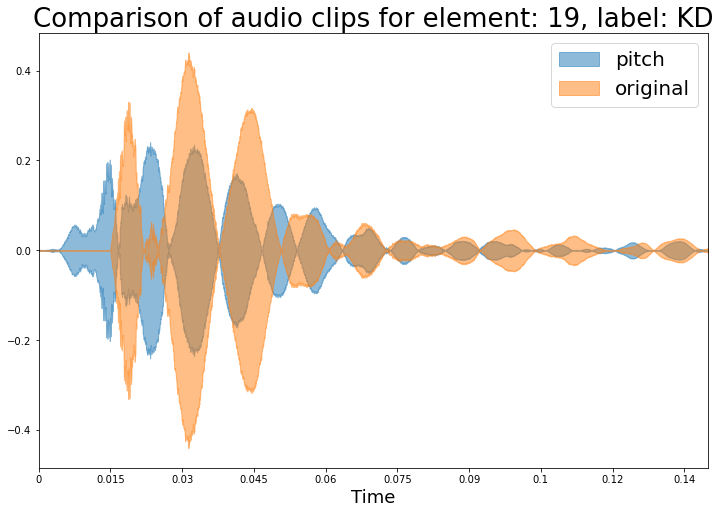

In [13]:
augment_audio.compare_waveforms(
    df=aug_audio_df, i=i,
    signal_cols=['pitch_aug', 'audio_wav_resample'],
    signal_labs=['pitch', 'original'],
    alpha=0.5,
    fontsizes=[26, 18, 20],
    figsize=(12, 8)
)

For element 19 (kick drum), the reverb effect is clearly visible as the second series of 3 peaks.

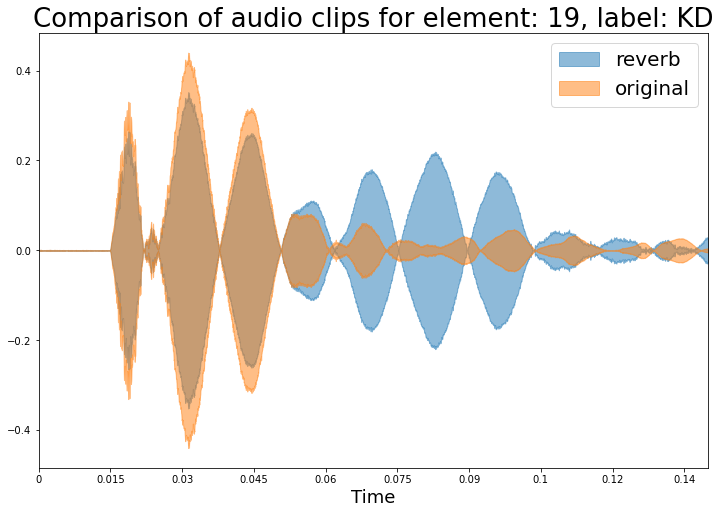

In [14]:
augment_audio.compare_waveforms(
    df=aug_audio_df, i=i,
    signal_cols=['reverb_aug', 'audio_wav_resample'],
    signal_labs=['reverb', 'original'],
    alpha=0.5,
    fontsizes=[26, 18, 20],
    figsize=(12, 8)
)

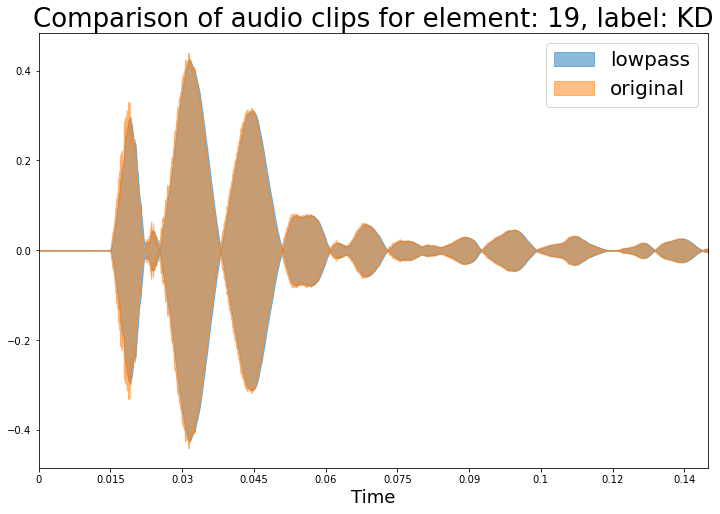

In [15]:
# This is a case where the sound difference is audible, but visually the waveforms are quite similar
augment_audio.compare_waveforms(
    df=aug_audio_df, i=i,
    signal_cols=['lowpass_aug', 'audio_wav_resample'],
    signal_labs=['lowpass', 'original'],
    alpha=0.5,
    fontsizes=[26, 18, 20],
    figsize=(12, 8)
)

# Spectrogram augmentation

Transforming the waveform to a Mel-spectrogram (or Mel-freqency cepstral coefficient) is relatively straightforward when using `librosa`'s built in functions. Then we'll try our hand at spectrogram masking, which is accomplished by setting sub-arrays or spans of the spectrogram to the background signal or other value (mean, median, etc).

In [16]:
aug_audio_df['mel_spec'] = aug_audio_df['audio_wav_resample'].progress_apply(lambda x: librosa.feature.melspectrogram(y=x, sr=SAMPLE_RATE, n_mels=128, fmax=8000))
# aug_audio_df['mfcc'] = aug_audio_df['audio_wav_resample'].progress_apply(lambda x: librosa.feature.mfcc(y=x, sr=SAMPLE_RATE))

  0%|          | 0/100 [00:00<?, ?it/s]

By using the default settings shown below, `augment_spectrogram_spans` creates fairly small spans, with random placement. These settings can be customized to create a more dramatic, or minimal, masking effect.

In [17]:
# Tip: try changing sig_val to np.median or other scalar values to see how the resulting masking changes
aug_audio_df['mel_spec_masked'] = aug_audio_df.mel_spec.progress_apply(lambda x: augment_audio.augment_spectrogram_spans(x, spans=3, span_ranges=[[1,5], [2,6]], span_variation=1, sig_val=np.min(x))) 

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# adjust i below to quickly compare spectrograms
i = 6 # Instance 6 is a Snare Drum
label = aug_audio_df.loc[i].label

Note: The masking value is set to the minimum (a proxy for background) to enhance visibility in the second plot, though this can be adjusted as needed.

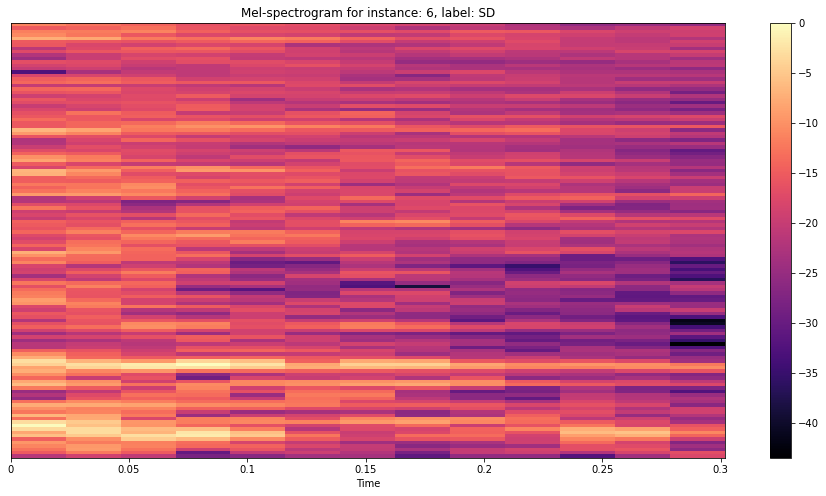

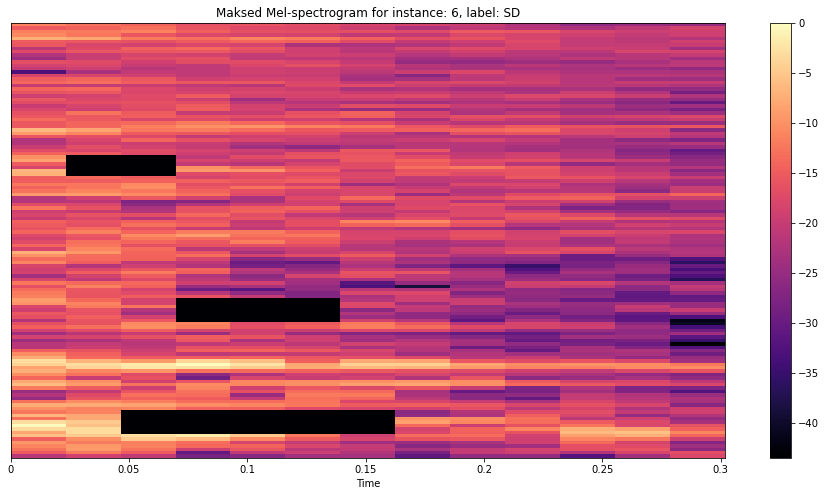

In [19]:
# before masking
plt.figure(figsize=(16,8))
librosa.display.specshow(librosa.power_to_db(aug_audio_df.loc[i, 'mel_spec'], ref=np.max), x_axis='time')
plt.colorbar()
plt.title('Mel-spectrogram for instance: {}, label: {}'.format(i, label));

# after masking
plt.figure(figsize=(16,8))
librosa.display.specshow(librosa.power_to_db(aug_audio_df.loc[i, 'mel_spec_masked'], ref=np.max), x_axis='time')
plt.colorbar()
plt.title('Maksed Mel-spectrogram for instance: {}, label: {}'.format(i, label));